# Welcome to the NoisePy Colab Tutorial

This tutorial will demonstrate how to use NoisePy to compute cross correlations and perform measurements of changes in seismic velocities


First, we install the noisepy-seis package

In [ ]:
#! pip install noisepy-seis --upgrade
# !pip uninstall noisepy-seis
# !conda install -n noisepy ipykernel --update-deps --force-reinstall
# !cd ..
# !pip install -e ".[dev]"
# !cd Jupyter_notebook

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. Restart the runtime now for proper installation of ```obspy``` on Colab.

Then we import the basic modules

In [2]:
from noisepy.seis import download, cross_correlate, stack, plotting_modules
from noisepy.seis.asdfstore import ASDFRawDataStore, ASDFCCStore
from noisepy.seis.datatypes import ConfigParameters
from dateutil.parser import isoparse
from noisepy.seis import noise_module
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
from obspy.signal.filter import bandpass


logger = logging.getLogger(__name__)
#path = "/content/data" # for use in Colab
path = os.path.expanduser("~/data") # for local runs
print(path)

MAX_MEM = 4.0

os.makedirs(path,exist_ok=True)
raw_data_path = os.path.join(path, "RAW_DATA")
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")

/home/seismic/data


## Ambient Noise Project Configuration

We store the metadata information about the ambient noise cross correlation workflow in a ConfigParameters() object. We first initialize it, then we tune the parameters for this cross correlation.

In [3]:
config = ConfigParameters() # default config parameters which can be customized
config.inc_hours = 12
config.start_date =  isoparse("2019-06-01")
config.end_date = isoparse("2019-06-05")
config.samp_freq= 20  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600.0  # (float) basic unit of data length for fft (sec)
    # criteria for data selection
config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)


config.acorr_only = True  # only perform auto-correlation or not
config.xcorr_only = False  # only perform cross-correlation or not

config.inc_hours = 12 # if the data is first 

config.lamin = 31       # min latitude
config.lamax = 42       # max latitude
config.lomin = -124     # min longitude
config.lomax = -115     # max longitude
config.net_list = ["CI"] # look for all network codes
config.stations = ["LJR*"]


 # pre-processing parameters
config.step= 1800.0  # (float) overlapping between each cc_len (sec)
config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
config.rm_resp= "inv"  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',
config.freqmin = 0.01
config.freqmax = 1.0
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# TEMPORAL and SPECTRAL NORMALISATION
config.freq_norm= "rma"  # choose between "rma" for a soft whitenning or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)

config.time_norm = "no"  # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
    # TODO: change time_norm option from "no" to "None"
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)

config.cc_method= "xcorr"  # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations

config.maxlag= 200  # lags of cross-correlation to save (sec)
config.substack = True

## Step 0: download data


This step will download data using obspy and save them into ASDF files locally. The data will be stored for each time chunk defined in hours by inc_hours.

The download will clean up the raw data by detrending, removing the mean, bandpassing (broadly), removing the instrumental response, merging gaps, ignoring too-gappy data.

Use the function ```download``` with the following arguments: 
* ```path``` of where to put the data
* ``` config```: Configuration Object.
* ```client_url_key```: the string for FDSN clients

Some raw parameters are still hardcoded in the download function that calles S0A_download_ASDF_MPI.py
I broadened the lat-long search, this could be a parameter in the config.


In [4]:
# Download data locally. Enters raw data path, channel types, stations, config, and fdsn server.
download(raw_data_path, config, "SCEDC")

2023-06-07 02:09:13,756 INFO S0A_download_ASDF_MPI download Download
        From: 2019-06-01T00:00:00.000000Z
        To: 2019-06-05T00:00:00.000000Z
        Stations: ['LJR*']
        Channels: ['BHE', 'BHN', 'BHZ']
        
2023-06-07 02:09:24,270 INFO noise_module preprocess_raw removing response for CI.LJR..BHE | 2019-06-01T00:00:00.000000Z - 2019-06-01T11:59:59.950000Z | 20.0 Hz, 864000 samples using inv
2023-06-07 02:09:25,300 INFO S0A_download_ASDF_MPI download downloading data   1.54 s; pre-process   1.14 s
2023-06-07 02:09:29,539 INFO noise_module preprocess_raw removing response for CI.LJR..BHN | 2019-06-01T00:00:00.000000Z - 2019-06-01T11:59:59.950000Z | 20.0 Hz, 864000 samples using inv
2023-06-07 02:09:30,586 INFO S0A_download_ASDF_MPI download downloading data   0.92 s; pre-process   1.12 s
2023-06-07 02:09:34,337 INFO noise_module preprocess_raw removing response for CI.LJR..BHZ | 2019-06-01T00:00:00.000000Z - 2019-06-01T11:59:59.950000Z | 20.0 Hz, 864000 samples using 

List the files that were downloaded, just to make sure !

In [5]:
print(os.listdir(raw_data_path))

['station.txt', '2019_06_01_00_00_00T2019_06_01_12_00_00.h5', '2019_06_01_12_00_00T2019_06_02_00_00_00.h5', '2019_06_02_00_00_00T2019_06_02_12_00_00.h5', '2019_06_02_12_00_00T2019_06_03_00_00_00.h5', '2019_06_03_00_00_00T2019_06_03_12_00_00.h5', '2019_06_03_12_00_00T2019_06_04_00_00_00.h5', '2019_06_04_00_00_00T2019_06_04_12_00_00.h5', '2019_06_04_12_00_00T2019_06_05_00_00_00.h5']


Plot the raw data, make sure it's noise!

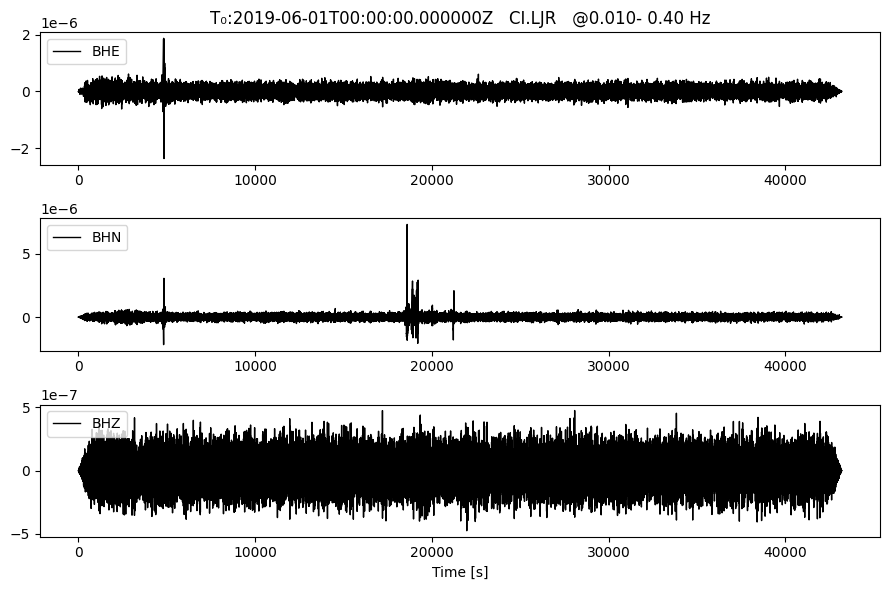

In [6]:
file = os.path.join(raw_data_path, "2019_06_01_00_00_00T2019_06_01_12_00_00.h5")
plotting_modules.plot_waveform(file,'CI','LJR',0.01,0.4) # this function takes for input: filename, network, station, freqmin, freqmax for a bandpass filter

## Step 1: Cross-correlation

This step will perform the cross correlation. For each time chunk, it will read the data, perform classic ambient noise pre-processing (time and frequency normalization), FFT, cross correlation, substacking, saving cross correlations in to a temp ASDF file (this is not fast and will be improved).


In [7]:
# For this tutorial make sure the previous run is empty
os.system(f"rm -rf {cc_data_path}")

0

In [8]:
config.freq_norm = "rma"
raw_store = ASDFRawDataStore(raw_data_path) # Store for reading raw data
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

# print the configuration parameters. Some are chosen by default but we cab modify them
print(config)

start_date=datetime.datetime(2019, 6, 1, 0, 0) end_date=datetime.datetime(2019, 6, 5, 0, 0) samp_freq=20 cc_len=3600.0 lamin=31 lamax=42 lomin=-124 lomax=-115 step=1800.0 freqmin=0.01 freqmax=1.0 freq_norm='rma' time_norm='no' cc_method='xcorr' smooth_N=10 smoothspect_N=10 substack=True substack_len=3600.0 maxlag=200 inc_hours=12 max_over_std=10 ncomp=3 stationxml=False rm_resp='inv' rm_resp_out='VEL' respdir='/home/seismic/data/RAW_DATA/../resp' acorr_only=True xcorr_only=False stack_method='linear' keep_substack=False rotation=True correction=False down_list=False net_list=['CI'] stations=['LJR*'] channels=['BHE', 'BHN', 'BHZ']


Perform the cross correlation

In [9]:
cross_correlate(raw_store, config, cc_store)

2023-06-07 02:11:42,572	INFO worker.py:1625 -- Started a local Ray instance.
2023-06-07 02:11:43,166 INFO utils log TIMING: 2.3419 for Ray init
2023-06-07 02:11:43,166 INFO S1_fft_cc_MPI cross_correlate 
2023-06-07 02:11:43,169 INFO asdfstore _get_dataset_cached ASDFCCStore - Opening /home/seismic/data/CCF/2019_06_01_00_00_00T2019_06_01_12_00_00.h5
2023-06-07 02:11:43,171 INFO asdfstore _get_dataset_cached ASDFCCStore - Opening /home/seismic/data/RAW_DATA/2019_06_01_00_00_00T2019_06_01_12_00_00.h5
2023-06-07 02:11:43,216 INFO utils log TIMING: 0.0449 for get channels
(read_data_ray pid=1711190) 2023-06-07 02:11:45,174 INFO asdfstore _get_dataset_cached ASDFCCStore - Opening /home/seismic/data/RAW_DATA/2019_06_01_00_00_00T2019_06_01_12_00_00.h5
2023-06-07 02:11:45,260 INFO S1_fft_cc_MPI _filter_channel_data Picked 20.0 as the closest sampling frequence to 20. Filtered to 3/3 channels
2023-06-07 02:11:45,260 INFO utils log TIMING: 2.0448 for read channel data
(preprocess_ray pid=1711190)

2023-06-07 02:11:54,755 INFO utils log TIMING: 1.5096 for Process the chunk of 2019-06-03T12:00:00+0000 - 2019-06-04T00:00:00+0000
2023-06-07 02:11:54,757 INFO asdfstore _get_dataset_cached ASDFCCStore - Opening /home/seismic/data/CCF/2019_06_04_00_00_00T2019_06_04_12_00_00.h5
2023-06-07 02:11:54,758 INFO asdfstore _get_dataset_cached ASDFCCStore - Opening /home/seismic/data/RAW_DATA/2019_06_04_00_00_00T2019_06_04_12_00_00.h5
2023-06-07 02:11:54,795 INFO utils log TIMING: 0.0370 for get channels
2023-06-07 02:11:54,823 INFO S1_fft_cc_MPI _filter_channel_data Picked 20.0 as the closest sampling frequence to 20. Filtered to 3/3 channels
2023-06-07 02:11:54,824 INFO utils log TIMING: 0.0290 for read channel data
2023-06-07 02:11:55,932 INFO utils log TIMING: 1.1076 for preprocess
2023-06-07 02:11:56,034 INFO utils log TIMING: 0.1018 for Compute FFTs
2023-06-07 02:11:56,038 INFO utils log TIMING: 0.0034 for ray.put(ffts)
2023-06-07 02:11:56,039 INFO utils log TIMING: 0.0050 for Created 3 C

Plot a single set of the cross correlation

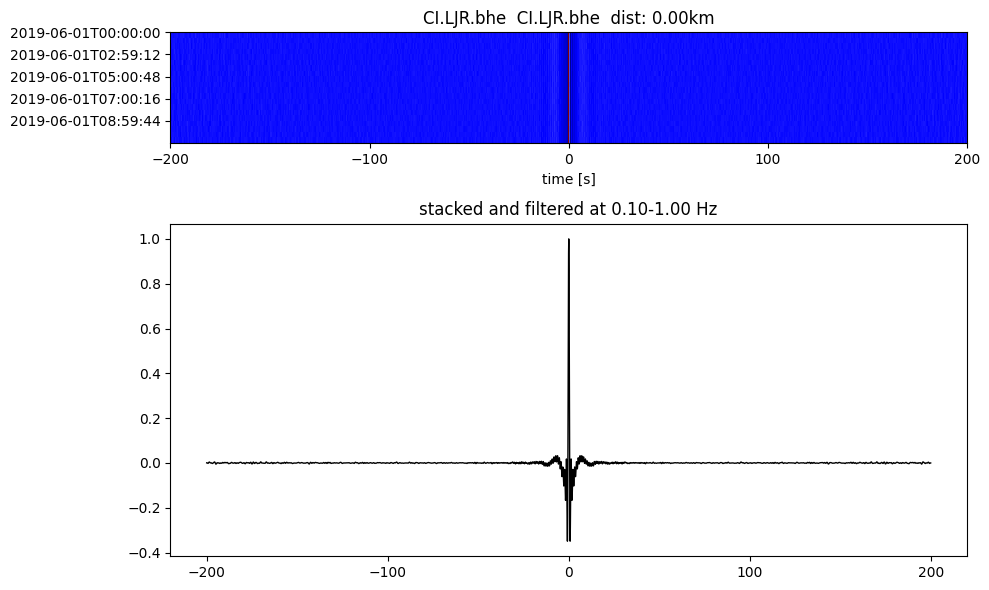

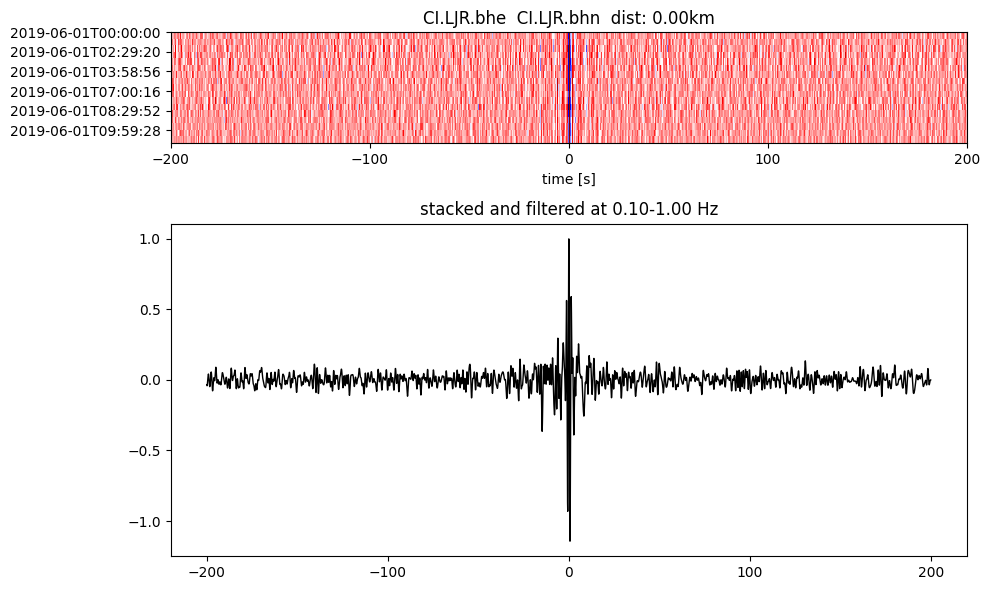

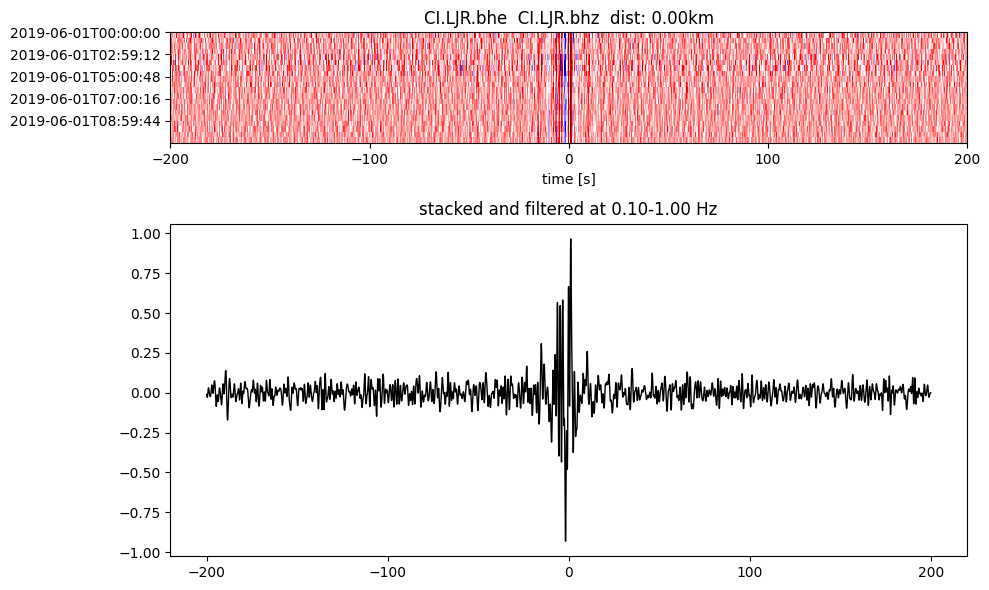

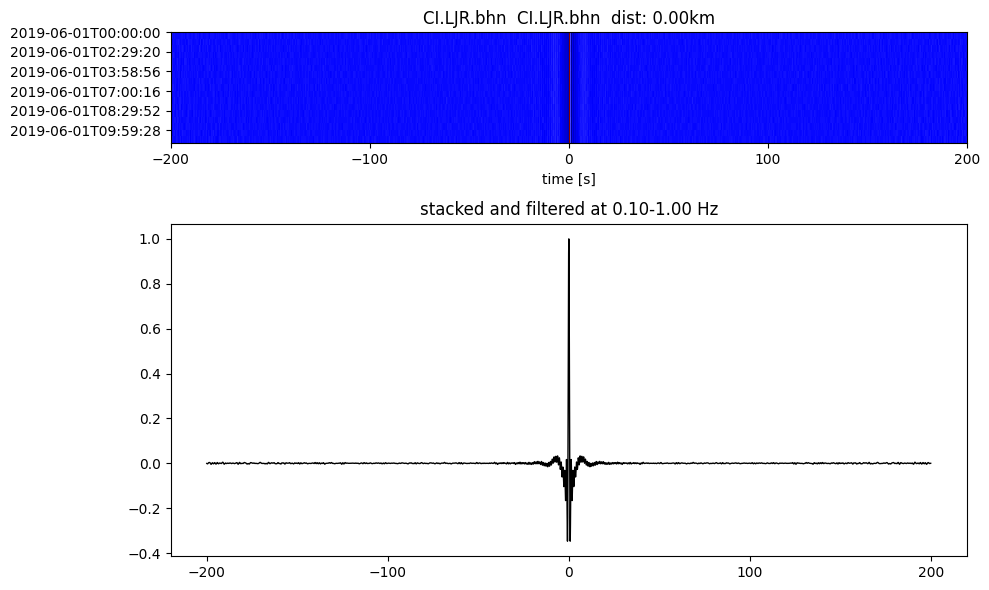

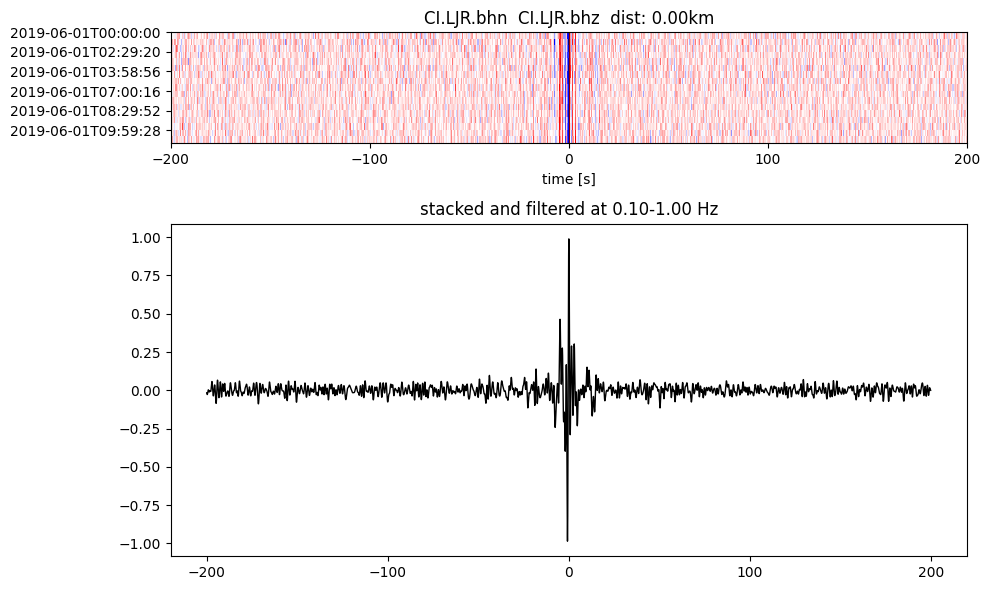

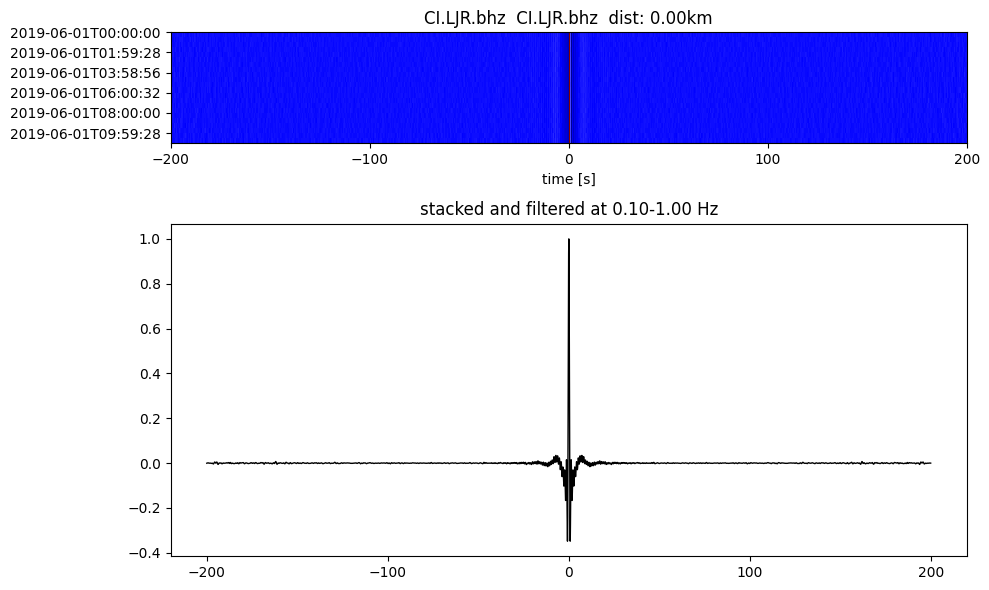

In [10]:
file = os.path.join(cc_data_path, '2019_06_01_00_00_00T2019_06_01_12_00_00.h5')
plotting_modules.plot_substack_cc(file,0.1,1,200,False)

## Step 2: Look at invidual traces and make dv/v measurements


Some parameters

In [11]:

# targeted component
stack_method = "linear"  # which stacked data to measure dispersion info
ccomp = "EN"  # cross component

# pre-defined group velocity to window direct and code waves
vmin = 0.8  # minimum velocity of the direct waves -> start of the coda window
lwin = 150  # window length in sec for the coda waves

# basic parameters
freq = [1, 2., 3., 5.]  # targeted frequency band for waveform monitoring
nfreq = len(freq) - 1
onelag = False  # make measurement one one lag or two
norm_flag = True  # whether to normalize the cross-correlation waveforms
do_stretch = True  # use strecthing method or not
do_dtw = False  # use dynamic time warping method or not
do_mwcs = True  # use moving-window cross spectrum method or not
do_mwcc = False  # use moving-window cross correlation method or not
do_wts = True  # use wavelet streching method or not
do_wxs = True  # use wavelet cross spectrum method or not

# parameters for stretching method
epsilon = 2 / 100  # limit for dv/v (in decimal)
nbtrial = 50  # number of increment of dt [-epsilon,epsilon] for the streching

# parameters for DTW
mlag = 50  # maxmum points to move (times dt gives the maximum time shifts)
b = 5  # strain limit (to be tested)
direct = 1  # direction to accumulate errors (1=forward, -1=backward)

# parameters for MWCS & MWCC
move_win_sec = 1.2 * int(1 / np.min(freq))  # moving window length (in sec)
step_sec = 0.3 * move_win_sec  # step for moving window sliding (in sec)

# parameters for wavelet domain methods
dj = 1 / 12  # Spacing between discrete scales. Default value is 1/12.
s0 = -1  # Smallest scale of the wavelet. Default value is 2*dt.
J = -1  # Number of scales less one.
wvn = "morlet"  # wavelet class



Find all of the H5 files with the cross correlation in the cc_store

In [12]:
timespans=cc_store.get_timespans()
pairs_all = list(set(pair for ts in timespans for pair in cc_store.get_station_pairs(ts)))
stations = set(pair[0] for pair in pairs_all)
print(timespans)
print(pairs_all)
print(stations)

[2019-06-01T00:00:00+0000 - 2019-06-01T12:00:00+0000, 2019-06-01T12:00:00+0000 - 2019-06-02T00:00:00+0000, 2019-06-02T00:00:00+0000 - 2019-06-02T12:00:00+0000, 2019-06-02T12:00:00+0000 - 2019-06-03T00:00:00+0000, 2019-06-03T00:00:00+0000 - 2019-06-03T12:00:00+0000, 2019-06-03T12:00:00+0000 - 2019-06-04T00:00:00+0000, 2019-06-04T00:00:00+0000 - 2019-06-04T12:00:00+0000, 2019-06-04T12:00:00+0000 - 2019-06-05T00:00:00+0000]
[(CI.LJR, CI.LJR)]
{CI.LJR}


In [13]:
sta_pair = pairs_all[0]
src_sta = sta_pair[0]
rec_sta = sta_pair[0]
print(src_sta,rec_sta)

CI.LJR CI.LJR


Add on functions to calculate the number of segments

In [14]:
from typing import Tuple
import logging
def calc_segments(fft_params: ConfigParameters, num_chunk: int) -> Tuple[int, int]:
    if fft_params.substack:  # things are difference when do substack
        if fft_params.substack_len == fft_params.cc_len:
            num_segmts = int(np.floor((fft_params.inc_hours * 3600 - fft_params.cc_len) / fft_params.step))
        else:
            num_segmts = int(fft_params.inc_hours / (fft_params.substack_len / 3600))
    npts_segmt = int(2 * fft_params.maxlag * fft_params.samp_freq) + 1
    memory_size = num_chunk * num_segmts * npts_segmt * 4 / 1024**3

    if memory_size > MAX_MEM:
        raise ValueError(
            "Require %5.3fG memory but only %5.3fG provided)! Cannot load cc data all once!" % (memory_size, MAX_MEM)
        )
    logger.debug("Good on memory (need %5.2f G and %s G provided)!" % (memory_size, MAX_MEM))
    return num_segmts, npts_segmt

In [15]:
# calculate the number of segments
num_segmts, npts_segmt = calc_segments(config, len(timespans)*config.ncomp**2)
num_chunk = len(timespans) 
print(f"there are ",num_segmts," segments/windows and ",npts_segmt," points in each segments and overall",num_chunk," number of time chunks")

there are  22  segments/windows and  8001  points in each segments and overall 8  number of time chunks


In [16]:
nccomp=config.ncomp**2
cc_array = np.zeros((nccomp*num_chunk * num_segmts, npts_segmt), dtype=np.float32)
cc_time = np.zeros(nccomp*num_chunk * num_segmts, dtype=np.float32)
cc_ngood = np.zeros(nccomp*num_chunk * num_segmts, dtype=np.int16)
cc_comp = np.chararray(nccomp*num_chunk * num_segmts, itemsize=2, unicode=True)
print(cc_array.shape)

(1584, 8001)


In [17]:
iseg = 0
for ts in timespans:
  # load the data from daily compilation
  ch_pairs = cc_store.get_channeltype_pairs(ts, src_sta, rec_sta)
  print(ch_pairs)
  logger.debug(f"path_list for {src_sta}-{rec_sta}: {ch_pairs}")

  # load the 9-component data, which is in order in the ASDF
  for ch_pair in ch_pairs:
      src_chan, rec_chan = ch_pair
      tcmp1 = src_chan.get_orientation()
      tcmp2 = rec_chan.get_orientation()

      # read data and parameter matrix
      tparameters, tdata = cc_store.read(ts, src_sta, rec_sta, src_chan, rec_chan)
      ttime = tparameters["time"]
      tgood = tparameters["ngood"]
      if config.substack:
          for ii in range(tdata.shape[0]):
              cc_array[iseg] = tdata[ii]
              cc_time[iseg] = ttime[ii]
              cc_ngood[iseg] = tgood[ii]
              cc_comp[iseg] = tcmp1 + tcmp2
              iseg += 1
      else:
          cc_array[iseg] = tdata
          cc_time[iseg] = ttime
          cc_ngood[iseg] = tgood
          cc_comp[iseg] = tcmp1 + tcmp2
          iseg += 1
print(iseg)

[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
[(bhe, bhe), (bhe, bhn), (bhe, bhz), (bhn, bhn), (bhn, bhz), (bhz, bhz)]
886


In [18]:
print(cc_array.shape)


(1584, 8001)


Once the data is stored in memory, we follow these steps:
* bandpass the data in a given frequency band, 
* stack to get a reference, 
* measure dv/v, save it into a pandas daataframe

9


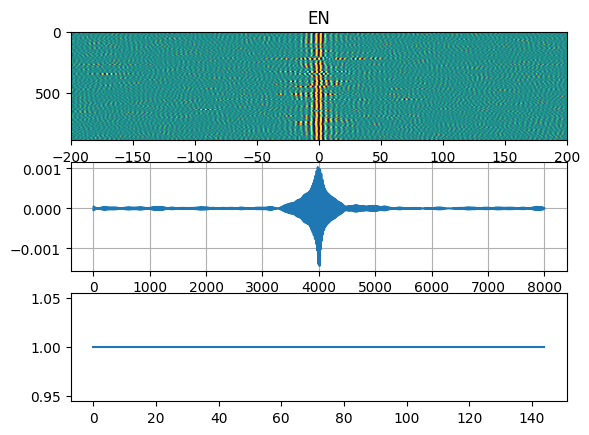

In [19]:
enz_system = ["EE", "EN", "EZ", "NE", "NN", "NZ", "ZE", "ZN", "ZZ"]
nccomp=config.ncomp**2
print(nccomp)
freq1=freq[0]
freq2=freq[1]
dt=1/config.samp_freq

## Choose a component
comp = "EN"

# for icomp in range(1,nccomp):
#   comp = enz_system[icomp]
  # select only the data from the same cross-component cross correlations 
  # and that have sufficiently good windows
indx = np.where( (cc_comp.lower() == comp.lower()) & cc_ngood==1)[0]


# bandpass filter the data. 
tcur = np.zeros(shape=(len(indx),npts_segmt))
for i in range(len(indx)):
  tcur[i,:]=bandpass(cc_array[indx[i]], freq1, freq2, int(1 / dt), corners=4, zerophase=True)

fig,ax=plt.subplots(3,1)
ax[0].imshow(tcur,extent=[-config.maxlag,config.maxlag,iseg,0],aspect='auto',vmin=-0.0001,vmax=0.0001)
ax[0].set_title(comp)


# output stacked data
(
    cc_final,
    ngood_final,
    stamps_final,
    tref,
    allstacks2,
    allstacks3,
    nstacks,
) = noise_module.stacking(tcur, cc_time[indx], cc_ngood[indx], config)
ax[1].plot(tref);ax[1].grid(True)
ax[2].plot(ngood_final)

First, we will explore the stability of the correlations with respect to the reference.

We will first select a short window in the coda

In [20]:
nwin = len(indx)  # number of windows to stack.
n2 = npts_segmt//2 # halfway in the cross correlation functions
t1 = 5. # starts at 5 seconds
t2 = 20. # ends at 15 seconds.
pwin_indx = n2+ np.arange(int(t1/dt),int(t2/dt)) # coda indexes in the positive lags
nwin_indx = n2 - np.arange(int(t1/dt),int(t2/dt))[::-1] # coda indexes in the negative lags
nwin_indx = nwin_indx[::-1] # flip time axes
print(pwin_indx)
print(nwin_indx)

[4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113
 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127
 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141
 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155
 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169
 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183
 4184 4185 4186 4187 4188 4189 4190 4191 4192 4193 4194 4195 4196 4197
 4198 4199 4200 4201 4202 4203 4204 4205 4206 4207 4208 4209 4210 4211
 4212 4213 4214 4215 4216 4217 4218 4219 4220 4221 4222 4223 4224 4225
 4226 4227 4228 4229 4230 4231 4232 4233 4234 4235 4236 4237 4238 4239
 4240 4241 4242 4243 4244 4245 4246 4247 4248 4249 4250 4251 4252 4253
 4254 4255 4256 4257 4258 4259 4260 4261 4262 4263 4264 4265 4266 4267
 4268 4269 4270 4271 4272 4273 4274 4275 4276 4277 4278 4279 4280 4281
 4282 4283 4284 4285 4286 4287 4288 4289 4290 4291 4292 4293 4294 4295
 4296 

Calculate the cross correlation between the coda and the reference coda

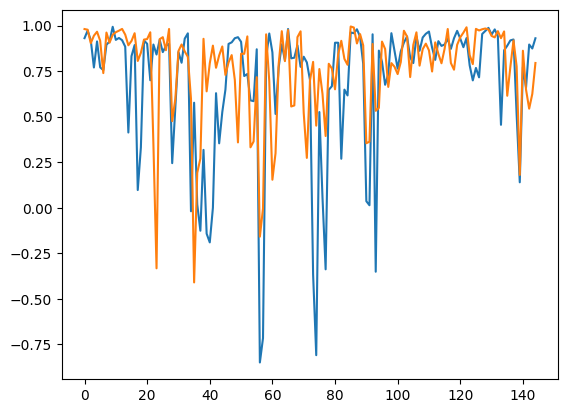

In [21]:
pcor_cc = np.zeros(shape=(nwin), dtype=np.float32)
ncor_cc = np.zeros(shape=(nwin), dtype=np.float32)
for i in range(nwin):
  pcor_cc[i] = np.corrcoef(tref[pwin_indx], tcur[i, pwin_indx])[0, 1]
  ncor_cc[i] = np.corrcoef(tref[nwin_indx], tcur[i, nwin_indx])[0, 1]
plt.plot(pcor_cc)
plt.plot(ncor_cc)

The result is not great! Typically one tries to get a CC coefficient at least up to 0.8 before doing the dv/v measurements.

We will go ahead anyway and refine later.

Initialize all kinds of dv/v

In [22]:

dvv_stretch = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_dtw = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_mwcs = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_wcc = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_wts = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_wxs = np.zeros(shape=(nwin, 4), dtype=np.float32)



In [23]:
para=dict()
para["freq"] = [freq1, freq2]
para["twin"] = [t1,t2]
para["dt"] = dt

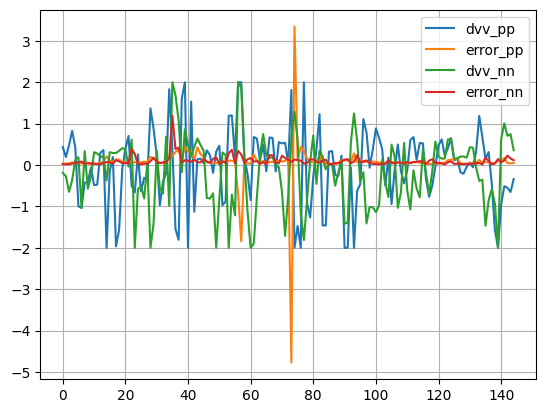

In [24]:
for ii in range(nwin):
        # casual and acasual lags for both ref and cur waveforms
        pcur = tcur[ii, pwin_indx]
        ncur = tcur[ii, nwin_indx]
        pref = tref[pwin_indx]
        nref = tref[nwin_indx]

        # functions working in time domain
        if do_stretch:
            (
                dvv_stretch[ii, 0],
                dvv_stretch[ii, 1],
                cc,
                cdp,
            ) = noise_module.stretching(pref, pcur, epsilon, nbtrial, para)
            (
                dvv_stretch[ii, 2],
                dvv_stretch[ii, 3],
                cc,
                cdp,
            ) = noise_module.stretching(nref, ncur, epsilon, nbtrial, para)

plt.plot(dvv_stretch);plt.legend(('dvv_pp','error_pp','dvv_nn','error_nn'));plt.grid(True)

Now as an exercise, here is what we can try:

* save the data in a data frame with the correct timestamps. Save using PyArrow
* compare with other cross components
* add much more data, make substacks (maybe 12-hour stacks), to get a more stabl result.
* change  the frequency band
* compare MWCS and Stretching.
* try other stations for single-station correlations
* try inter-station cross correlation